<a href="https://colab.research.google.com/github/yualapshina/distrib-lab2/blob/master/distrib_lab2_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# препроцессинг

In [1]:
!git clone https://github.com/yualapshina/distrib-lab2.git --quiet

In [11]:
import os
import random
from IPython.display import Image

# выполненные задачи

Из трёх предложенных для лабораторной работы задач реализована первая. Если быть точнее, полностью реализованы задачи умножения матрицы на вектор с разбиением по строкам и по столбцам. Что касается задачи с блочным разбиением: к сожалению, возникли неточности с реализацией непосредственно алгоритмической части (правильное разбиение вектора), хотя мы были готовы продемонстрировать навыки работы с MPI. Неловко, конечно. Естественно, это не заслуживает полной оценки за задачу, но "удовлетворительно" за лабу (3 или 4 из 5 баллов за задачу плюс балл за отчёт, при условии качественной реализации всего этого, разумеется) нас бы вполне устроило.

Посмотрим на сам код:
- бенчмарк - простая программа без какого-либо разбиения, вычисляющая произведение стандартным циклом по строкам. Послужить нам для сравнения времени и заодно корректности вычислений.
- строки - вычисление происходит путём распределения строк между процессами. для обмена информацией используются такие инструменты MPI, как Bcast (для размера  и вектора) и Scatterv (для разбиения матрицы). Каждый процесс обладает полной копией вектора, результат вычислений для каждой строки продставляет собой число. В финальный ответ эти числа комбинируются функцией Allgatherv - собираются в единый вектор согласно рангам сообщающих их процессов. Общее направление рассуждений и конкретные алгоритмы, например, подсчитывание индексов для разбиения матрицы, были основаны на программе-примере из учебника Гергеля.
- столбцы - вычисление происходит путём распределения строк между процессами. Раздача информации происходит похожим образом, но реализована добавлением нового массива, следящего за отступами, потому что делить пришлось в несколько этапов (в отличие от простого ленточного разбиения, которое так хорошо реализовывалось в первой задаче). В результате функция Scatterv оказалась в цикле, где последовательно разделяет элементы столбцов, итерируясь по строкам. При вычислении подзадач здесь используется только один элемент вектора, поэтому он разделяется этой же функцией - а результаты представляют собой векторы совпадающей с ответом размерности, которые необходимо просуммировать, и это осуществляется с помощью Allreduce.
- блоки - разбиение осуществлялось практически так же, только с неправильными на данный момент алгоритмами выбора индексов. а вот сборку ответа планировалось осуществить чуть более "вручную" - отправкой и получением отдельных сообщений между процессами. пример употребления Send и Recv в коде всё ещё существует.

Формат входных данных:
- первая строка - одно целое число size. задаёт длину вектора и размерность матрицы (работаем только с квадратными матрицами)
- следующие size строк по size вещественных чисел задают матрицу
- следующая строка длиной size вещественных чисел задаёт вектор

В следующих ячейках есть пример и непосредственная генерация.

Выходные данные (и так оформлены human-readable, но на всякий случай) - вычисленный программой вектор и засечённое внутри неё самой время выполнения.

In [5]:
# редактировать ввод
size = 3

input_content = str(size) + "\n";
for i in range(size + 1):
  for j in range(size):
    input_content += str(random.randint(0, 50)) + " "
  input_content += "\n"

with open("distrib-lab2/input_vector.txt", "w") as fin:
  fin.write(input_content);

In [6]:
# проверить ввод
with open("distrib-lab2/input_vector.txt", "r") as fin:
  check_content = fin.read()
print(check_content)

3
40 25 27 
41 40 37 
39 31 26 
23 6 47 



In [7]:
# количество процессов
os.environ['p'] = '4'

In [8]:
%%shell
cd distrib-lab2

mpicc benchmark_vector.c -o benchmark_vector -lm
mpiexec --allow-run-as-root ./benchmark_vector input_vector.txt

mpicc mpi_rows.c -o mpi_rows -lm
mpiexec --oversubscribe -np $p --allow-run-as-root ./mpi_rows input_vector.txt

mpicc mpi_columns.c -o mpi_columns -lm
mpiexec --oversubscribe -np $p --allow-run-as-root ./mpi_columns input_vector.txt

Benchmark
Time: 0.000002 seconds
Result: 2339.00 2922.00 2305.00 

MPI Rows
Time: 0.000354 seconds
Result: 2339.00 2922.00 2305.00 

MPI Columns
Time: 0.001119 seconds
Result: 2339.00 2922.00 2305.00 



# оценка

Ну что можно сказать в целом: несмотря на все старания в реализации, сравнение общего времени работы неутешительно. Между двумя версиями с разбиением, однако, разницы практически нет.

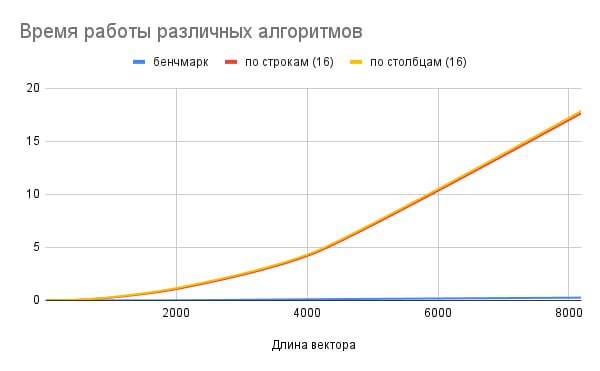

In [13]:
Image('distrib-lab2/pictures/timing_common.jpg')

Посмотрим сначала на строки.

При сравнении времени процессов некая оптимизация всё же заметна, а значит, мы всё же написали не беспросветную ерунду. На графиках ускорения и эффективности есть сегменты роста, хотя потом они снова меняют тенденцию на падение, да и в целом ускорение даже не достигает единицы.

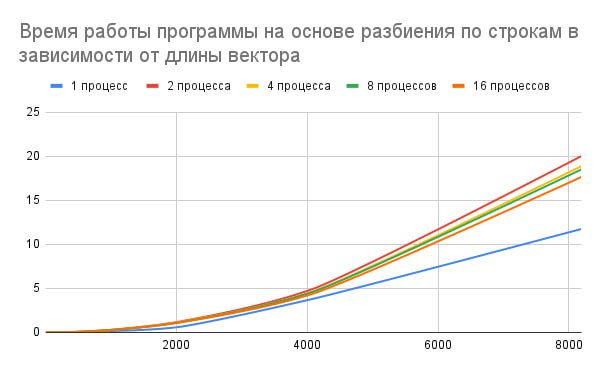

In [14]:
Image('distrib-lab2/pictures/timing_rows.jpg')

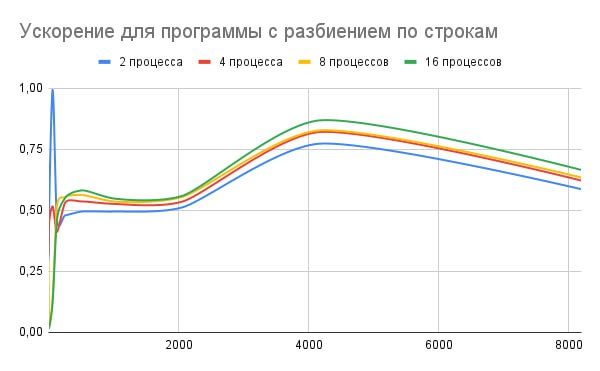

In [15]:
Image('distrib-lab2/pictures/speedup_rows.jpg')

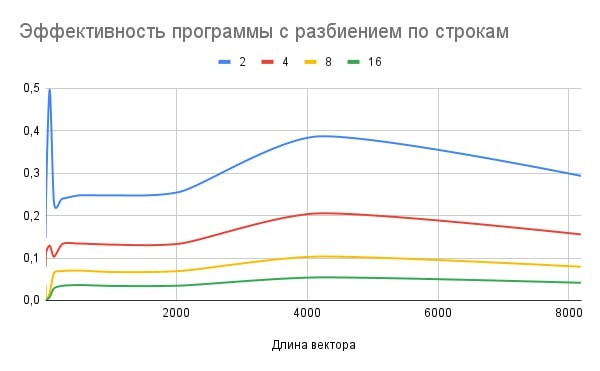

In [16]:
Image('distrib-lab2/pictures/efficiency_rows.jpg')

Общая динамика строкового алгоритма в целом та же самая. Он не демонстрирует резких прыжков ускорения, но скорее потому, что в целом просто хуже.

Кажется, как минимум в рамках рассмотренного нами объёма данных - и исключительно в версии нашей неидеальной реализации - никакой выгоды от этих алгоритмов не видно.

:(

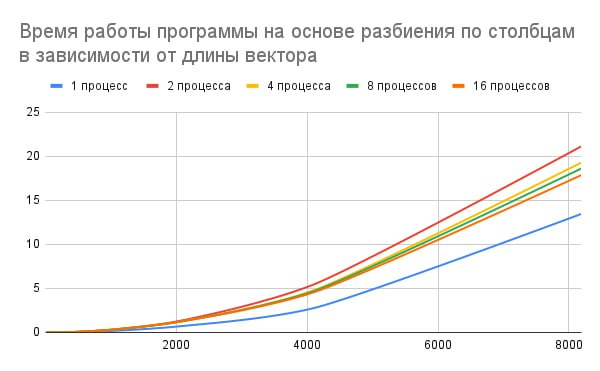

In [17]:
Image('distrib-lab2/pictures/timing_columns.jpg')

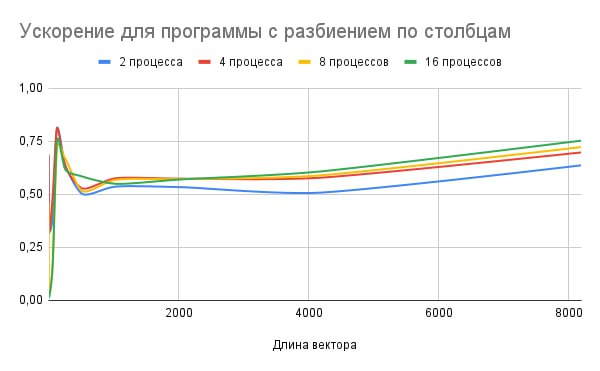

In [18]:
Image('distrib-lab2/pictures/speedup_columns.jpg')

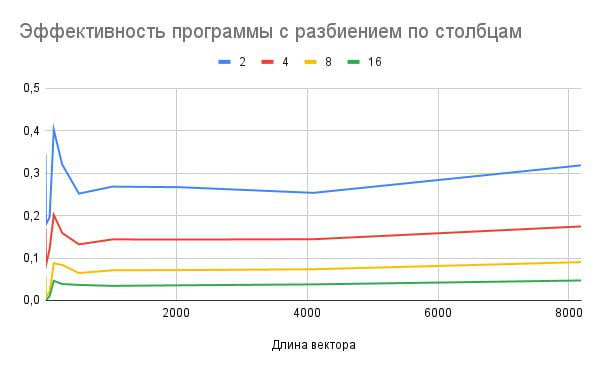

In [19]:
Image('distrib-lab2/pictures/efficiency_columns.jpg')